In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize_scalar

def helstrom_operator(q0, rho0, rho1):
    return q0*rho0 - (1-q0)*rho1

In [2]:
def pauli_matrices(string):
    if string == 'x':
        return np.array([[0, 1], [1, 0]])
    elif string == 'y':
        return np.array([[0, -i], [i,0]])
    elif string == 'z':
        return np.array([[1, 0], [0, -1]])

def identity_matrix(n):
    return np.identity(n)

In [3]:
def simple_qubit_example(nu, pauli_matrix):
    i2 = identity_matrix(2)
    rho0 = (i2 + (1-nu)*pauli_matrix)/2
    rho1 = (i2 - (1-nu)*pauli_matrix)/2
    return rho0, rho1

In [4]:
rho0, rho1 = simple_qubit_example(0.8, pauli_matrices('z'))

In [5]:
def state_copies(rho, M):
    result = rho
    for _ in range(M-1):
        result = np.kron(result, rho)
    return result

In [6]:
def helstrom_bound(q, rho0, rho1):
    return (1 - np.linalg.norm(q0*rho0 - (1-q0)*rho1))/2

In [7]:
def chernoff_error_exponent(rho0, rho1):
    def chernoff_coefficient(s):
        product = np.dot(fractional_matrix_power(rho0, s), fractional_matrix_power(rho1, 1-s))
        return np.real(np.trace(product))

    res = minimize_scalar(chernoff_coefficient, bounds=(0,1), method='bounded')

    if not res.success:
        raise RuntimeError("Minimization Failed")

    c_opt = res.fun
    return -np.log(c_opt)

In [8]:
def get_helstrom_povm_multicopy(rho_plus: np.ndarray, rho_minus: np.ndarray, M: int = 1):
    """
    Returns the Helstrom POVM (Pi_plus, Pi_minus) for M-copy discrimination between
    rho_plus and rho_minus (equal priors assumed).

    Requires: state_copies(rho, M)
    """
    # Use user-defined Kronecker power function
    rho_plus_M = state_copies(rho_plus, M)
    rho_minus_M = state_copies(rho_minus, M)

    # Helstrom operator: delta = q * rho_plus_M - (1 - q) * rho_minus_M with q = 1/2
    delta = 0.5 * (rho_plus_M - rho_minus_M)

    eigvals, eigvecs = np.linalg.eigh(delta)

    # Construct POVM elements from eigenvectors
    Pi_plus = np.zeros_like(delta)
    Pi_minus = np.zeros_like(delta)

    for i in range(len(eigvals)):
        projector = np.outer(eigvecs[:, i], eigvecs[:, i])
        if eigvals[i] > 0:
            Pi_plus += projector
        else:
            Pi_minus += projector

    return Pi_plus, Pi_minus

In [9]:
#def simulate_one_measurement(rho_plus, rho_minus, Pi_plus, Pi_minus, M=1):
#    """
#    Simulates a single measurement trial.
#    Randomly selects one of the true states (equal priors), applies the M-copy Helstrom POVM,
#    and returns the guessed label and true label.
#    """
    # Choose true state randomly (equal priors)
#    true_label = np.random.choice([+1, -1])

    # Get the true state
#    rho_true = rho_plus if true_label == +1 else rho_minus
#    rho_true_M = state_copies(rho_true, M)

    # Compute probabilities of each POVM outcome
#    p_plus = np.real(np.trace(Pi_plus @ rho_true_M))
#    p_minus = np.real(np.trace(Pi_minus @ rho_true_M))

    # Sample outcome from probabilities
#    outcome = np.random.choice([+1, -1], p=[p_plus, p_minus])

#    return outcome, true_label


In [ ]:
def simulate_majority_vote(rho_plus, rho_minus, Pi_plus, Pi_minus, N, M = 1):
    """
    Simulates N independent single-copy measurements and returns whether
    the majority vote is correct.
    """
    # Choose one true label for all copies in this trial
    true_label = np.random.choice([+1, -1])
    rho_true = rho_plus if true_label == +1 else rho_minus

    votes = []

    for _ in range(N):
        rho_true_M = state_copies(rho_true, M)
        p_plus = np.real(np.trace(Pi_plus @ rho_true_M))
        p_minus = np.real(np.trace(Pi_minus @ rho_true_M))
        vote = np.random.choice([+1, -1], p=[p_plus, p_minus])
        votes.append(vote)

    vote_total = np.sum(votes)
    guess = +1 if vote_total > 0 else -1  # Tie breaks to -1
    is_correct = (guess == true_label)

    return is_correct


In [ ]:
def estimate_error_exponent(rho_plus, rho_minus, Pi_plus, Pi_minus, N, num_trials=10000, M = 1):
    """
    Runs num_trials majority-vote simulations for N single-copy measurements.
    Returns estimated error probability and error exponent ε_N = -log(Pe)/N
    """
    num_errors = 0

    for _ in range(num_trials):
        correct = simulate_majority_vote(rho_plus, rho_minus, Pi_plus, Pi_minus, N, M)
        if not correct:
            num_errors += 1

    P_err = num_errors / num_trials
    if P_err == 0:
        epsilon_N = np.inf  # perfect classification
    else:
        epsilon_N = -np.log(P_err) / N

    return P_err, epsilon_N


In [ ]:
v = 0.8
rho_plus, rho_minus = simple_qubit_example(0.8, pauli_matrices('z'))
Pi_plus, Pi_minus = get_helstrom_povm_multicopy(rho_plus, rho_minus, M=1)
set_of_P_err = []
set_of_eps_N = []

for N in range(1, 100):
    P_err, epsilon_N = estimate_error_exponent(rho_plus, rho_minus, Pi_plus, Pi_minus, N, num_trials=10000, M = 1)
    print(f"N = {N} → P_err = {P_err:.5f}, ε_N = {epsilon_N:.5f}")
    set_of_eps_N.append(epsilon_N)
    set_of_P_err.append(P_err)


N = 1 → P_err = 0.39780, ε_N = 0.92181
N = 2 → P_err = 0.39390, ε_N = 0.46583
N = 3 → P_err = 0.35670, ε_N = 0.34362
N = 4 → P_err = 0.34380, ε_N = 0.26692
N = 5 → P_err = 0.31920, ε_N = 0.22839
N = 6 → P_err = 0.31700, ε_N = 0.19148
N = 7 → P_err = 0.28110, ε_N = 0.18129
N = 8 → P_err = 0.27910, ε_N = 0.15952
N = 9 → P_err = 0.26630, ε_N = 0.14701
N = 10 → P_err = 0.27020, ε_N = 0.13086
N = 11 → P_err = 0.24500, ε_N = 0.12786
N = 12 → P_err = 0.23990, ε_N = 0.11896


KeyboardInterrupt: 

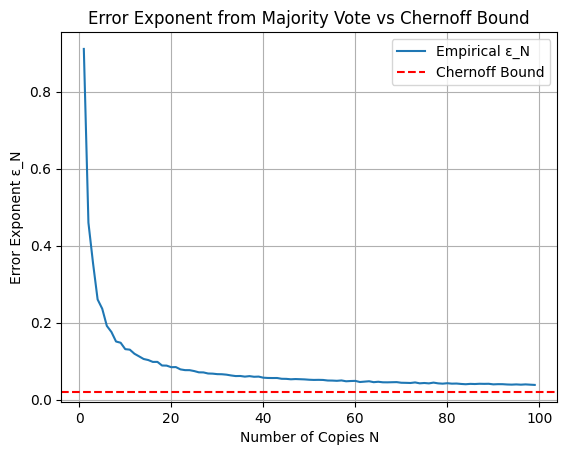

In [ ]:

# Assume set_of_eps_N is a list of ε_N for N = 1 to 999
Ns = list(range(1, 100))  # N starts at 1

plt.plot(Ns, set_of_eps_N, label="Empirical ε_N")
plt.axhline(y=chernoff_error_exponent(rho0, rho1), color='r', linestyle='--', label='Chernoff Bound')
plt.xlabel("Number of Copies N")
plt.ylabel("Error Exponent ε_N")
plt.title("Error Exponent from Majority Vote vs Chernoff Bound")
plt.legend()
plt.grid(True)
plt.show()


In [47]:

set_of_eps_even_M = []
set_of_eps_odd_M = []
rho_plus, rho_minus = simple_qubit_example(0.8, pauli_matrices('z'))
N = 10

for M in range(1, 100):
    rho_plus_M = state_copies(rho_plus, M)
    rho_minus_M = state_copies(rho_minus, M)
    Pi_plus, Pi_minus = get_helstrom_povm_multicopy(rho_plus, rho_minus, M=M)
    if M % 2 == 0:
        _, epsilon_M = estimate_error_exponent(rho_plus_M, rho_minus_M, Pi_plus, Pi_minus, int(N/M), num_trials=10000)
        print(f'even : {epsilon_M}')
        set_of_eps_even_M.append(epsilon_M)
    elif M % 2 != 0:
        _, epsilon_M = estimate_error_exponent(rho_plus_M, rho_minus_M, Pi_plus, Pi_minus, int(np.rint(N/M)), num_trials=10000)
        print(f'odd : {epsilon_M}')
        set_of_eps_odd_M.append(epsilon_M)
        

odd : 0.13220058712375288
even : 0.18714568515332602
odd : 0.4226593781006161
even : 0.48656283431334685
odd : 0.5662914041196315
even : 1.1482227892214443
odd : 1.2542140207626828
even : 1.2269003089696406
odd : 1.2942622756733968


KeyboardInterrupt: 

In [ ]:
set_of_eps_even_M

[np.float64(0.18745180766207029),
 np.float64(0.4768665136750126),
 np.float64(1.1488535051048565),
 np.float64(1.2461846531352454)]